In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm 
from matplotlib import pyplot as plt
import seaborn as sns

## Check inductive edge bank metrics

In [ ]:
data_name = 'uci'
def calculate_inductive_metric(data_name):
  node_feats = np.load(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}_node.npy')
  edge_feats = np.load(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}.npy')
  edge_data = pd.read_csv(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}.csv')

  num_nodes = node_feats.shape[0]
  node1 = torch.tensor(edge_data["u"].tolist())
  node2 = torch.tensor(edge_data["i"].tolist())
  ts = torch.tensor(edge_data["ts"].tolist())
  t_factor = 1
  pointer = 0
  min_time = ts[0]
  max_time = ts[-1]

  old_deg = torch.zeros(num_nodes)
  is_node_seen = torch.zeros(num_nodes, dtype = torch.bool)
  for max_cur_time_factor in torch.arange(0, 1/t_factor):
    while(ts[pointer] < min_time + (max_cur_time_factor+1)*t_factor*(max_time-min_time)):
      old_deg[node1[pointer]] += 1
      old_deg[node2[pointer]] += 1
      is_node_seen[node1[pointer]] = True
      is_node_seen[node2[pointer]] = True
      pointer += 1
    pointer2 = pointer
    is_node_seen2 = is_node_seen.copy()
    while(ts[pointer2] < min_time + (max_cur_time_factor+2)*t_factor*(max_time-min_time)):
      if is_node_seen2[node1[pointer2]]:
        neg_sample = torch.randint(0, num_nodes).item()
        pos_sample = node2
      else if is_node_seen2[node2[pointer2]]:
        
      
  count, deg = np.histogram(old_deg, bins = 10)
  count = torch.tensor(count)
  deg = torch.tensor(deg)[1:]
  sort_order = torch.argsort(count)
  # plt.stairs(count, deg)
  plt.plot(count[sort_order], deg[sort_order])
  plt.title(f'New Histogram for overall degree {data_name}')
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('degree')
  plt.ylabel('count')
  plt.show()
  plt.close()

## Draw degree histogram

In [50]:
def draw_degree_hist(data_name):
  node_feats = np.load(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}_node.npy')
  edge_feats = np.load(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}.npy')
  edge_data = pd.read_csv(f'/home/ayush/DyGLib/processed_data/{data_name}/ml_{data_name}.csv')

  num_nodes = node_feats.shape[0]
  node1 = torch.tensor(edge_data["u"].tolist())
  node2 = torch.tensor(edge_data["i"].tolist())
  ts = torch.tensor(edge_data["ts"].tolist())
  t_factor = 1
  pointer = 0
  min_time = ts[0]
  max_time = ts[-1]

  old_deg = torch.zeros(num_nodes)
  is_node_seen = torch.zeros(num_nodes, dtype = torch.bool)
  for max_cur_time_factor in torch.arange(0, 1/t_factor):
    while(ts[pointer] < min_time + (max_cur_time_factor+1)*t_factor*(max_time-min_time)):
      old_deg[node1[pointer]] += 1
      old_deg[node2[pointer]] += 1
      is_node_seen[node1[pointer]] = True
      is_node_seen[node2[pointer]] = True
      pointer += 1
  count, deg = np.histogram(old_deg, bins = 10, range = (0, float(old_deg.max()//10)))
  count = torch.tensor(count)/count.sum()
  deg = torch.tensor(deg)[1:]
  sort_order = torch.argsort(deg)
  # plt.stairs(count, deg)
  return deg[sort_order], count[sort_order]

In [51]:
ALL_DATASETS = ['reddit', "ia-slashdot-reply-dir", "ia-digg-reply", "ia-retweet-pol", "ia-escorts-dynamic", "ia-movielens-user2tags-10m"]

In [52]:
# ALL_DATASETS = ["SocialEvo", "uci", "Flights", "CanParl", "USLegis", "UNtrade", "UNvote", "Contacts", "mooc", "wikipedia", "reddit", "enron", "myket"]
data = {}
for data_name in ALL_DATASETS:
  data[data_name] = draw_degree_hist(data_name)

In [53]:
data

{'reddit': (tensor([ 587.2000, 1174.4000, 1761.6000, 2348.8000, 2936.0000, 3523.2000,
          4110.3999, 4697.6001, 5284.7998, 5872.0000]),
  tensor([9.8122e-01, 1.2035e-02, 2.6441e-03, 1.3676e-03, 1.2764e-03, 4.5587e-04,
          0.0000e+00, 5.4705e-04, 4.5587e-04, 0.0000e+00])),
 'ia-slashdot-reply-dir': (tensor([ 33.5000,  67.0000, 100.5000, 134.0000, 167.5000, 201.0000, 234.5000,
          268.0000, 301.5000, 335.0000]),
  tensor([9.7080e-01, 1.7643e-02, 5.8352e-03, 2.3693e-03, 1.2532e-03, 9.3990e-04,
          5.0912e-04, 1.9581e-04, 3.1330e-04, 1.3707e-04])),
 'ia-digg-reply': (tensor([ 3.1000,  6.2000,  9.3000, 12.4000, 15.5000, 18.6000, 21.7000, 24.8000,
          27.9000, 31.0000]),
  tensor([0.6544, 0.1509, 0.0717, 0.0409, 0.0256, 0.0191, 0.0137, 0.0090, 0.0070,
          0.0077])),
 'ia-retweet-pol': (tensor([ 10.2000,  20.4000,  30.6000,  40.8000,  51.0000,  61.2000,  71.4000,
           81.6000,  91.8000, 102.0000]),
  tensor([0.8979, 0.0482, 0.0204, 0.0125, 0.0061, 0.0

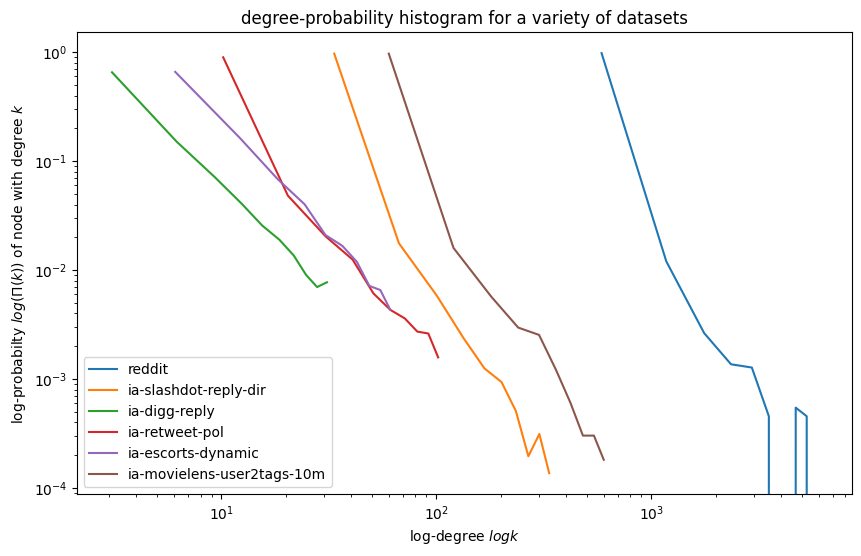

In [64]:
plt.figure(figsize=(10, 6))
for data_name, (deg, count) in data.items():  
  plt.plot(deg, count)
plt.title(f'degree-probability histogram for a variety of datasets')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'log-degree $log k$')
plt.ylabel(r'log-probabilty $log(\Pi(k))$ of node with degree $k$')
plt.legend(list(data.keys()))
plt.show()
plt.close()

In [80]:
def calculate_correlation(old_deg, new_node_new_deg):
  return float(torch.corrcoef(torch.cat((old_deg.unsqueeze(0), new_node_new_deg.unsqueeze(0)), dim = 0))[0, 1])

In [103]:
def calculate_all_correlations(node1, node2, ts, num_nodes, total_time, t1_factor = 0.05, t2_factor = 0.05):
  t1 = t1_factor * total_time
  t2 = t2_factor * total_time
  # indices corresponding to:
  p1 = 0  # start of the subgraph [t-t1-t2, t-t2)
  p2 = 0  # end of the subgraph [t-t1-t2, t-t2) and start of the subgraph [t-t2, t]
  p3 = 0  # end of the subgraph [t-t2, t]
  old_deg = torch.zeros(num_nodes)              # corresponds to the `degree` of each node in the subgraph [t-t1-t2, t-t2)
  new_node_new_deg = torch.zeros(num_nodes)     # corresponds to the `new node neighbor degree` of each node in the subgraph [t-t2, t]
  is_a_new_node = torch.ones(num_nodes, dtype=torch.bool)        # 1 if the node is unseen yet 0 otherwise
  is_a_new_node_edge = []   # stores is_a_new_node tuple for both the new nodes in [t-t2, t] subgraph
  correlations = []
  times = []
  is_first_time = True
  
  # Moving p3 from old timestamp to the next timestamp
  with tqdm(total=len(ts)) as pbar:
    while(p3 < len(ts)-1):
      if is_first_time:
        while(ts[p3] < t1 + t2):
          # Since this edge is entering the new subgraph [t-t2, t]
          # Add info to `is_a_new_node_edge` about whether the nodes are seen for the first time in this edge
          is_a_new_node_edge.append([is_a_new_node[node1[p3]], is_a_new_node[node2[p3]]])
          # If the nodes were unseen till now, then add 1 to the `new_node_new_deg` for the neighbour
          new_node_new_deg[node1[p3]] += int(is_a_new_node[node2[p3]])
          new_node_new_deg[node2[p3]] += int(is_a_new_node[node1[p3]])
          # Mark the nodes as seen
          is_a_new_node[node1[p3]] = False
          is_a_new_node[node2[p3]] = False
          # Move the counter ahead
          p3 += 1
          pbar.update(1)
        is_first_time = False
      else:
        # Since this edge is entering the new subgraph [t-t2, t]
        # Add info to `is_a_new_node_edge` about whether the nodes are seen for the first time in this edge
        is_a_new_node_edge.append([is_a_new_node[node1[p3]], is_a_new_node[node2[p3]]])
        # If the nodes were unseen till now, then add 1 to the `new_node_new_deg` for the neighbour
        new_node_new_deg[node1[p3]] += int(is_a_new_node[node2[p3]])
        new_node_new_deg[node2[p3]] += int(is_a_new_node[node1[p3]])
        # Mark the nodes as seen
        is_a_new_node[node1[p3]] = False
        is_a_new_node[node2[p3]] = False
        # Move the counter ahead
        p3 += 1
        pbar.update(1)
      
      while(ts[p2] < ts[p3]-t2):
        # Since this edge is going to the old subgraph [t-t1-t2, t-t2), add to the old_deg
        old_deg[node1[p2]] += 1
        old_deg[node2[p2]] += 1
        # Since this edge is coming from the new subgraph [t-t2, t]
        # If the other node was seen first at this edge (as indicated by the first element in `is_a_new_node_edge`, 
        # then remove 1 from the new_node_new_deg of this node)
        new_node_new_deg[node1[p2]] -= int(is_a_new_node_edge[0][1])
        new_node_new_deg[node2[p2]] -= int(is_a_new_node_edge[0][0])
        # Remove this edge from `is_a_new_node_edge` since it is no longer in the new subhraph [t-t2, t]
        is_a_new_node_edge = is_a_new_node_edge[1:]
        # Move the counter ahead
        p2 += 1
        
      while(ts[p1] < ts[p3]-t1-t2):
        # Since these edges are being removed from the old subgraph [t-t1-t2, t-t2), decrease old subgraph degree
        old_deg[node1[p1]] -= 1
        old_deg[node2[p1]] -= 1
        # Move the counter ahead
        p1 += 1
      
      correlations.append(calculate_correlation(old_deg, new_node_new_deg))
      times.append(ts[p3])
    return times, correlations

In [104]:
def calculate_correlation_plots(data_name = "wikipedia"):
  node_feats = np.load(f'/home/ayush/DyGLib/DG_data/{data_name}/ml_{data_name}_node.npy')
  num_nodes = node_feats.shape[0]
  edge_data = pd.read_csv(f'/home/ayush/DyGLib/DG_data/{data_name}/ml_{data_name}.csv')
  node1 = torch.tensor(edge_data["u"].tolist())
  node2 = torch.tensor(edge_data["i"].tolist())
  ts = torch.tensor(edge_data["ts"].tolist())
  
  # Check if they are sorted based on time
  new_ts = ts.clone().tolist()
  new_ts = sorted(new_ts)
  assert np.count_nonzero(np.array([new_ts[i] == ts[i] for i in range(len(ts))])) == len(ts)
  
  # Check if num_nodes is correct
  assert num_nodes == max(max(node1), max(node2)) + 1

  total_time = ts[-1] - ts[0]
  times, correlations = calculate_all_correlations(node1=node1, node2=node2, ts=ts, num_nodes=num_nodes, total_time=total_time, t1_factor = 0.05, t2_factor = 0.05)
  plt.plot(torch.arange(0, len(correlations)), correlations)
  plt.title(f'Correlation b/w old degree and new node neighbor degree for {data_name}')
  plt.show()

100%|█████████▉| 157473/157474 [00:37<00:00, 4228.98it/s]


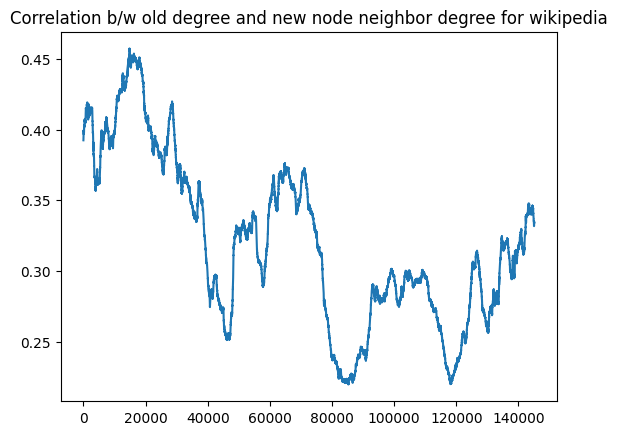

In [105]:
calculate_correlation_plots("wikipedia")

100%|█████████▉| 672446/672447 [03:22<00:00, 3320.33it/s]


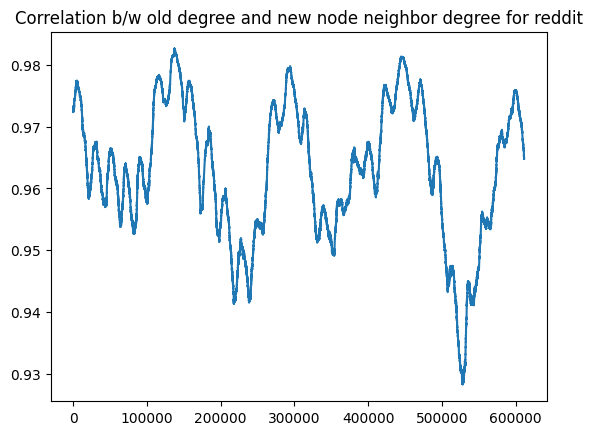

In [106]:
calculate_correlation_plots("reddit")